In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Load dataset
df = pd.read_csv('dataset.csv')  
df.drop('Customer_ID', axis=1, inplace=True)

In [88]:
df.head()

,Age,Gender,Annual_Income,Total_Spend,Years_as_Customer,Num_of_Purchases,Average_Transaction_Amount,Num_of_Returns,Num_of_Support_Contacts,Satisfaction_Score,Last_Purchase_Days_Ago,Email_Opt_In,Promotion_Response,Target_Churn
0,62,2,45.15,5892.58,5,22,453.80,2,0,3,129,1,1,1
1,65,1,79.51,9025.47,13,77,22.90,2,2,3,227,0,1,0
2,18,1,29.19,618.83,13,71,50.53,5,2,2,283,0,1,1
3,21,2,79.63,9110.30,3,33,411.83,5,3,5,226,1,0,1
4,21,2,77.66,5390.88,15,43,101.19,3,0,5,242,0,2,0


### Encoding Categorical Columns

In [93]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder for binary columns
le = LabelEncoder()

categorical_cols = ["Gender","Email_Opt_In","Promotion_Response","Target_Churn"]
encoder = LabelEncoder()
for col in categorical_cols:
    df_new[col] = encoder.fit_transform(df_new[col])

### Training Preperation

In [97]:
feature_cols = [
    'Total_Spend',
    'Annual_Income',
    'Last_Purchase_Days_Ago',
    'Average_Transaction_Amount',
    'Num_of_Purchases',
    'Age',
    'Years_as_Customer',
    'Num_of_Returns'
]
X = df[feature_cols]
y = df["Target_Churn"]

In [98]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state = 42,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [99]:
print(f"Train: {y_train.value_counts().to_frame()}")
print(f"Test: {y_test.value_counts().to_frame()}")
print(f"Validation: {y_val.value_counts().to_frame()}")

Train:               count
Target_Churn       
1               316
0               284
Test:               count
Target_Churn       
1               131
0               119
Validation:               count
Target_Churn       
1                79
0                71


## Feature Scaling

In [100]:
from sklearn.preprocessing import MinMaxScaler
import joblib

scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
joblib.dump(scaler, 'min_max.pkl')

['min_max.pkl']

In [ ]:
import joblib
import os
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb


def train_model(model_name, X_train, y_train, save_path, **kwargs):
    """
    Initialize, train, and save a scikit-learn model.

    Parameters:
    - model_name: str, name of the model (e.g., 'random_forest', 'xgboost', 'lightgbm')
    - X_train: training features
    - y_train: training labels
    - save_path: path to save the model (e.g., 'models/model.pkl')
    - **kwargs: additional parameters to pass into the model constructor
    """

    # Model registry
    model_dict = {
        "random_forest": RandomForestRegressor,
        "xgboost": xgb.XGBRegressor,
        "lightgbm": lgb.LGBMRegressor,
    }

    # Check if model_name is valid
    if model_name not in model_dict:
        raise ValueError(
            f"Unknown model '{model_name}'. Choose from: {list(model_dict.keys())}"
        )

    # Initialize model
    model = model_dict[model_name](**kwargs)

    # Train Model
    model.fit(X_train, y_train)

    # Save Model
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    joblib.dump(model, save_path)

    print(f"{model_name} model trained and saved to: {save_path}")


In [111]:
train_model(
    model_name="random_forest",
    X_train=X_train,
    y_train=y_train,
    save_path="models/rf.pkl",
    n_estimators=100,
    random_state=42,
)

random_forest model trained and saved to: models/rf.pkl


In [112]:
train_model(
    model_name="xgboost",
    X_train=X_train,
    y_train=y_train,
    save_path="models/xgb.pkl",
    objective='binary:logistic',   # binary classification task
    eval_metric='logloss',         # evaluation metric
)

xgboost model trained and saved to: models/xgb.pkl


In [114]:
train_model(
    model_name="lightgbm",
    X_train=X_train,
    y_train=y_train,
    save_path="models/lightgbm.pkl",
    objective='binary',   # binary classification task
    num_leaves = 70,
    n_estimators=300,
    learning_rate=0.01
)

[LightGBM] [Info] Number of positive: 316, number of negative: 284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 967
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.526667 -> initscore=0.106768
[LightGBM] [Info] Start training from score 0.106768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

## Hyperparameter Tunning

In [142]:
import xgboost as xgb

# Best hyperparameters obtained from GridSearchCV
best_params = {
    'subsample': 1.0,
    'reg_lambda': 0.3,
    'reg_alpha': 0.1,
    'n_estimators': 50,
    'max_depth': 8,
    'learning_rate': 0.01,
    'gamma': 0.3,
    'colsample_bytree': 1.0
}

# Initialize XGBoost model with best parameters
xgb_model = xgb.XGBClassifier(
    subsample=best_params['subsample'],
    reg_lambda=best_params['reg_lambda'],
    reg_alpha=best_params['reg_alpha'],
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    gamma=best_params['gamma'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42
)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

joblib.dump(xgb_model, 'models/xgb.pkl')

['models/xgb.pkl']

### Model Accuracy

In [115]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model_path, X_test, y_test):
    """
    Function to load a model from a pickle file, make predictions on the test set,
    and plot the confusion matrix as a heatmap.

    Parameters:
    - model_path: str, path to the saved model pickle file
    - X_test: pandas DataFrame or numpy array, features of the test set
    - y_test: pandas Series or numpy array, actual target values for the test set
    """
    # Load the trained model from pickle file

    model = joblib.load(model_path)
    
    # Predict using the loaded model
    y_test_pred = model.predict(X_test)
    
    # Generate the confusion matrix
    cf_knn = confusion_matrix(y_test, y_test_pred)
    
    # Plot the confusion matrix using a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cf_knn, annot=True, cmap="flare", linecolor="orange", fmt="d", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

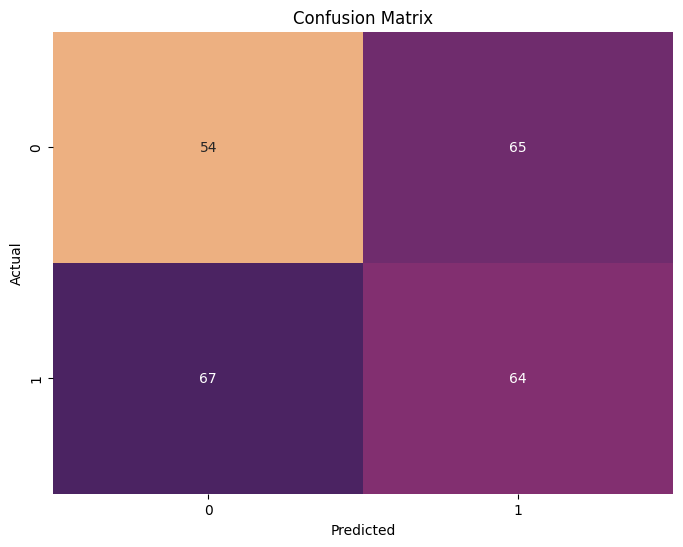

In [116]:
plot_confusion_matrix("models/rf.pkl", X_test, y_test)

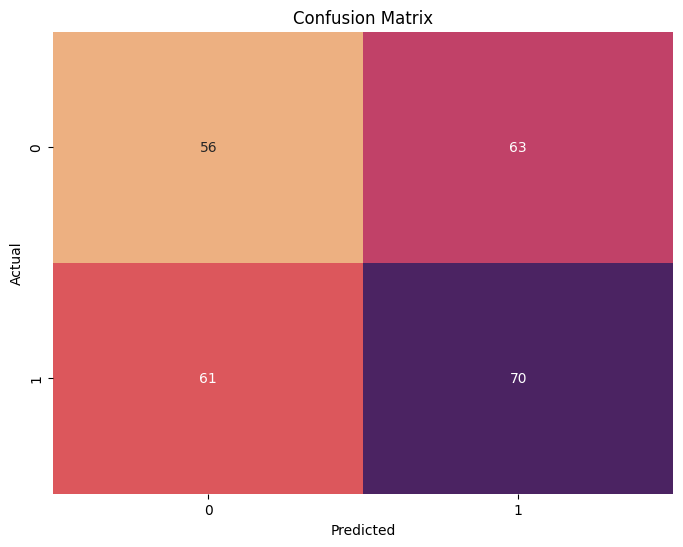

In [ ]:
plot_confusion_matrix("models/xgb.pkl", X_test, y_test) 

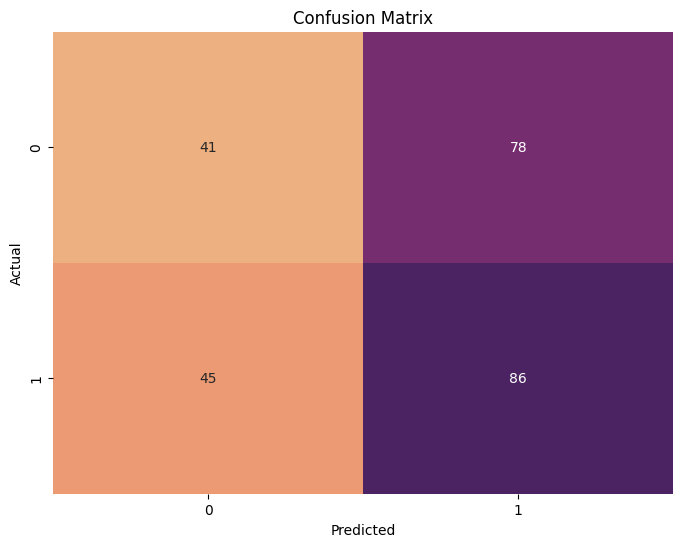

In [143]:
plot_confusion_matrix("models/xgb.pkl", X_test, y_test)

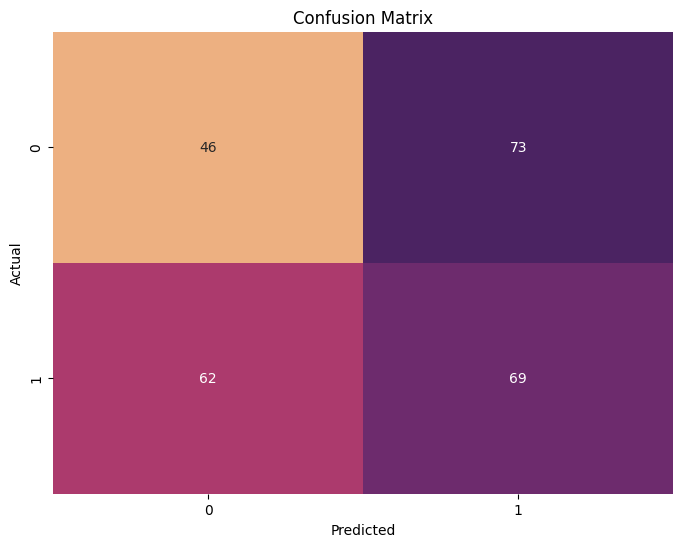

In [119]:
plot_confusion_matrix("models/lightgbm.pkl", X_test, y_test)

In [138]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score
import numpy as np

# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(random_state=42)

# Define the parameter distributions (randomized values)
param_dist = {
    'n_estimators': np.arange(50, 300, 50),        # Number of trees
    'max_depth': np.arange(3, 15, 1),               # Max depth of the trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],       # Learning rate
    'subsample': [0.7, 0.8, 0.9, 1.0],              # Fraction of samples for training
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],      # Fraction of features for each tree
    'gamma': [0, 0.1, 0.2, 0.3],                   # Regularization term
    'reg_alpha': [0, 0.1, 0.2],                     # L1 regularization
    'reg_lambda': [0.1, 0.2, 0.3]                   # L2 regularization
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit the randomized search
random_search.fit(X_train, y_train)

# Get the best parameters and best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_:.4f}")

# Use the best model to make predictions
best_xgb_model = random_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

# Evaluate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'subsample': 1.0, 'reg_lambda': 0.3, 'reg_alpha': 0.1, 'n_estimators': np.int64(50), 'max_depth': np.int64(8), 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 1.0}
Best Score: 0.5467
Test Accuracy: 0.5080


In [139]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],                # Number of trees
    'max_depth': [3, 6, 10],                         # Maximum depth of trees
    'learning_rate': [0.01, 0.05, 0.1],              # Step size
    'subsample': [0.8, 1.0],                         # Fraction of samples for training each tree
    'colsample_bytree': [0.8, 1.0],                   # Fraction of features used for each tree
    'gamma': [0, 0.1, 0.2],                          # Regularization parameter
    'reg_alpha': [0, 0.1, 0.2],                      # L1 regularization term
    'reg_lambda': [0.1, 0.2, 0.5]                    # L2 regularization term
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_:.4f}")

# Use the best model to make predictions
best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

# Evaluate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Fitting 5 folds for each of 2916 candidates, totalling 14580 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.2, 'reg_lambda': 0.5, 'subsample': 0.8}
Best Score: 0.5633
Test Accuracy: 0.4920


In [60]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

def cross_fold_validation_classification(model_name, X_train, y_train, **kwargs):
    """
    Perform cross-validation on a classification dataset using the specified model.
    
    Parameters:
    - model_name: str, model name to use (e.g., "Logistic", "Random", "Decision_Tree")
    - X_train: DataFrame or numpy array, features of the training set
    - y_train: DataFrame or numpy array, target labels for the training set
    - **kwargs: Additional parameters to pass to the model constructor
    """

    # Use StratifiedKFold for classification to ensure balanced class distributions
    stratified_cv = StratifiedKFold(n_splits=5)

    # Models dictionary for classification
    models = {
        "xgboost": xgb.XGBClassifier,
        "lightbgm": lgb.LGBMClassifier,
        "random_forest": RandomForestClassifier,
    }

    # Initialize the model
    model = models[model_name](**kwargs)

    # Perform cross-validation with the chosen model and scoring metric
    scores = cross_val_score(model, X_train, y_train, cv=stratified_cv, scoring="accuracy")

    print(f"Cross-validation Accuracy scores for {model_name}: {scores}")
    print(f"Mean Accuracy score: {scores.mean():.4f}")


In [61]:
cross_fold_validation_classification("xgboost", X_train, y_train)

Cross-validation Accuracy scores for xgboost: [0.5        0.525      0.5        0.49166667 0.58333333]
Mean Accuracy score: 0.5200


In [62]:
cross_fold_validation_classification("lightbgm", X_train, y_train)

[LightGBM] [Info] Number of positive: 253, number of negative: 227
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 823
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.527083 -> initscore=0.108439
[LightGBM] [Info] Start training from score 0.108439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [63]:
cross_fold_validation_classification("random_forest", X_train, y_train)

Cross-validation Accuracy scores for random_forest: [0.53333333 0.575      0.56666667 0.525      0.46666667]
Mean Accuracy score: 0.5333


In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the model
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [200, 400, 500],          # Number of trees in the forest
    'max_depth': [5, 10, 20],         # Maximum depth of the trees
    'min_samples_split': [2, 4, 5, 7],         # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 3],           # Minimum number of samples required at each leaf node
    'max_features': [None, 'sqrt', 'log2'], # The number of features to consider when looking for the best split
}

# Initialize GridSearchCV with RandomForestClassifier
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data (X_train, y_train)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_:.4f}")

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {test_accuracy:.4f}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Hyperparameters: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 400}
Best Accuracy: 0.5567
Test Set Accuracy: 0.5040


In [120]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model_performance(path, X_test, y_test):
    """
    Function to evaluate model performance with Accuracy, Precision, Recall, F1-score, and ROC-AUC.

    Parameters:
    - model: The trained classification model
    - X_test: Test set features
    - y_test: True target labels for the test set
    """
    
    model = joblib.load(path)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for ROC-AUC

    # Calculate Accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate Precision, Recall, and F1-score
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_prob)

    # Print the metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    # Plot the ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


Accuracy: 0.4720
Precision: 0.4961
Recall: 0.4885
F1-Score: 0.4923
ROC-AUC: 0.4709


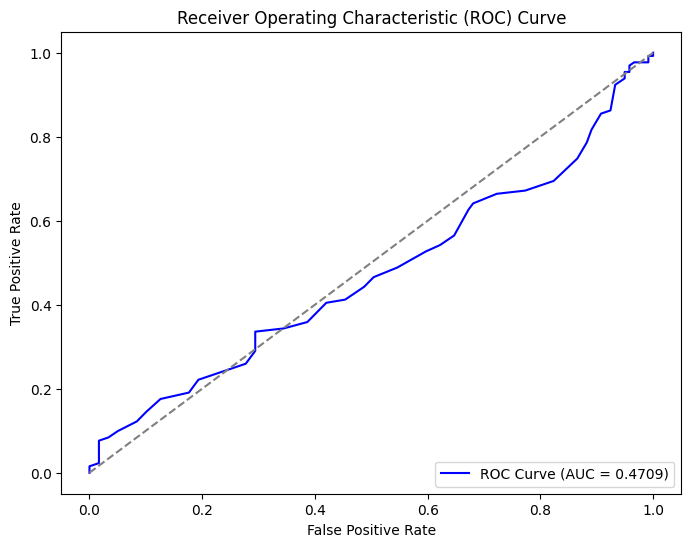

In [121]:
evaluate_model_performance("models/rf.pkl", X_test, y_test)

Accuracy: 0.5040
Precision: 0.5263
Recall: 0.5344
F1-Score: 0.5303
ROC-AUC: 0.4970


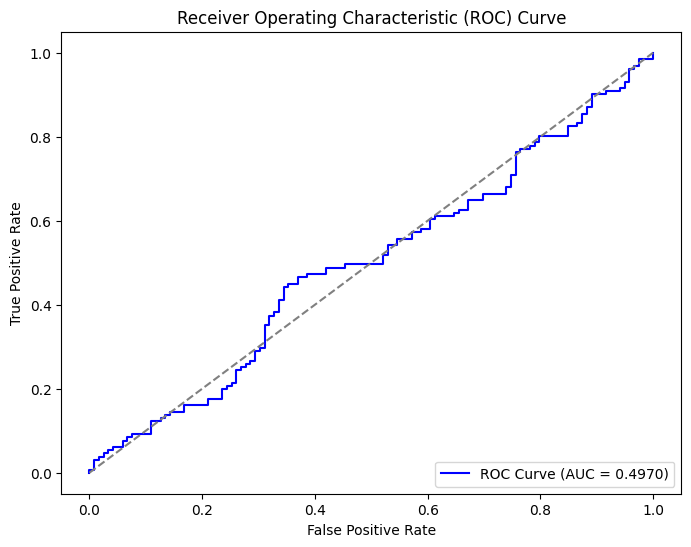

In [122]:
evaluate_model_performance("models/xgb.pkl", X_test, y_test)

Accuracy: 0.4600
Precision: 0.4859
Recall: 0.5267
F1-Score: 0.5055
ROC-AUC: 0.4735


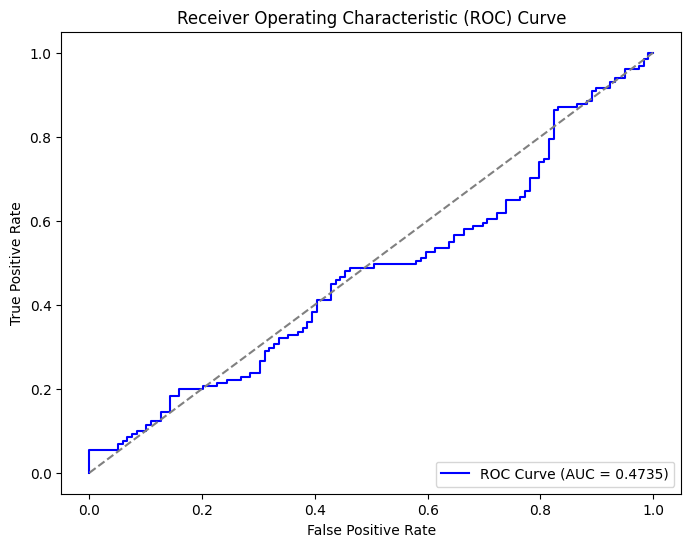

In [123]:
evaluate_model_performance("models/lightgbm.pkl", X_test, y_test)